In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import kagglehub
path=kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:",path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00" 
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"   
os.environ["TF_GPU_THREAD_MODE"]="gpu_private"  
os.environ["TF_XLA_FLAGS"]="--tf_xla_enable_xla_devices"

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path='/kaggle/input/brain-tumor-mri-dataset/Training'
test_path='/kaggle/input/brain-tumor-mri-dataset/Testing'

2025-04-24 16:36:01.563165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745512561.795707      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745512561.863118      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [5]:
val_test_datagen=ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

In [6]:
train_data=train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

Found 4571 images belonging to 4 classes.


In [7]:
val_data=val_test_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 1141 images belonging to 4 classes.


In [8]:
test_data=val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


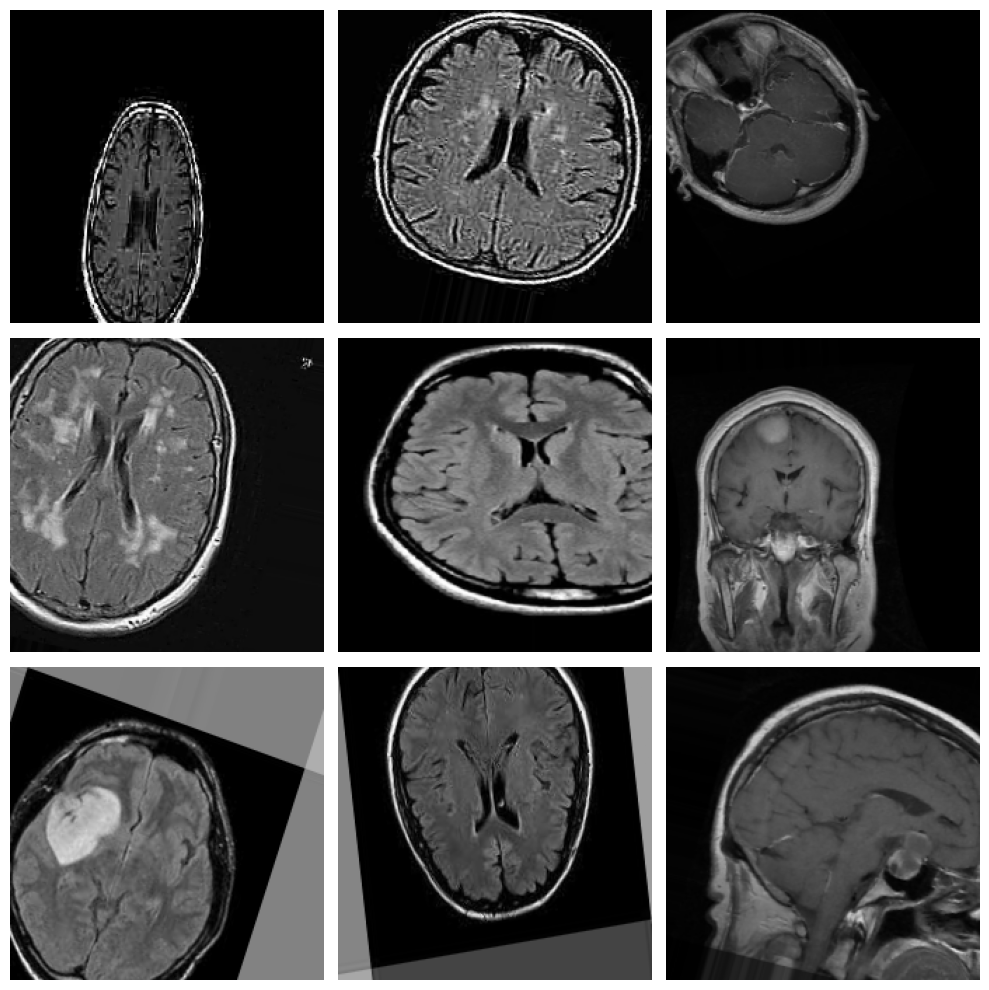

In [9]:
import matplotlib.pyplot as plt
sample_images,sample_labels=next(train_data)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(train_data.classes),y=train_data.classes)
class_weights_dict=dict(enumerate(class_weights))

In [11]:
print(class_weights_dict)

{0: 1.0811258278145695, 1: 1.0659981343283582, 2: 0.8955721003134797, 3: 0.9800600343053173}


In [12]:
from tensorflow.keras.applications import Xception
base_model=Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

I0000 00:00:1745512623.593950      31 service.cc:148] XLA service 0x1e9d6160 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745512623.594542      31 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1745512623.705296      31 service.cc:148] XLA service 0x1ceaa040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745512623.705334      31 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745512623.720088      31 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1745512623.723255      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
base_model.trainable=False

In [14]:
from tensorflow.keras import layers,models
model=models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(512,activation='silu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256,activation='silu'),
    layers.Dropout(0.3),
    layers.Dense(4,activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,622,956 (90.11 MB)

 Trainable params: 2,758,404 (10.52 MB)

 Non-trainable params: 20,864,552 (79.59 MB)

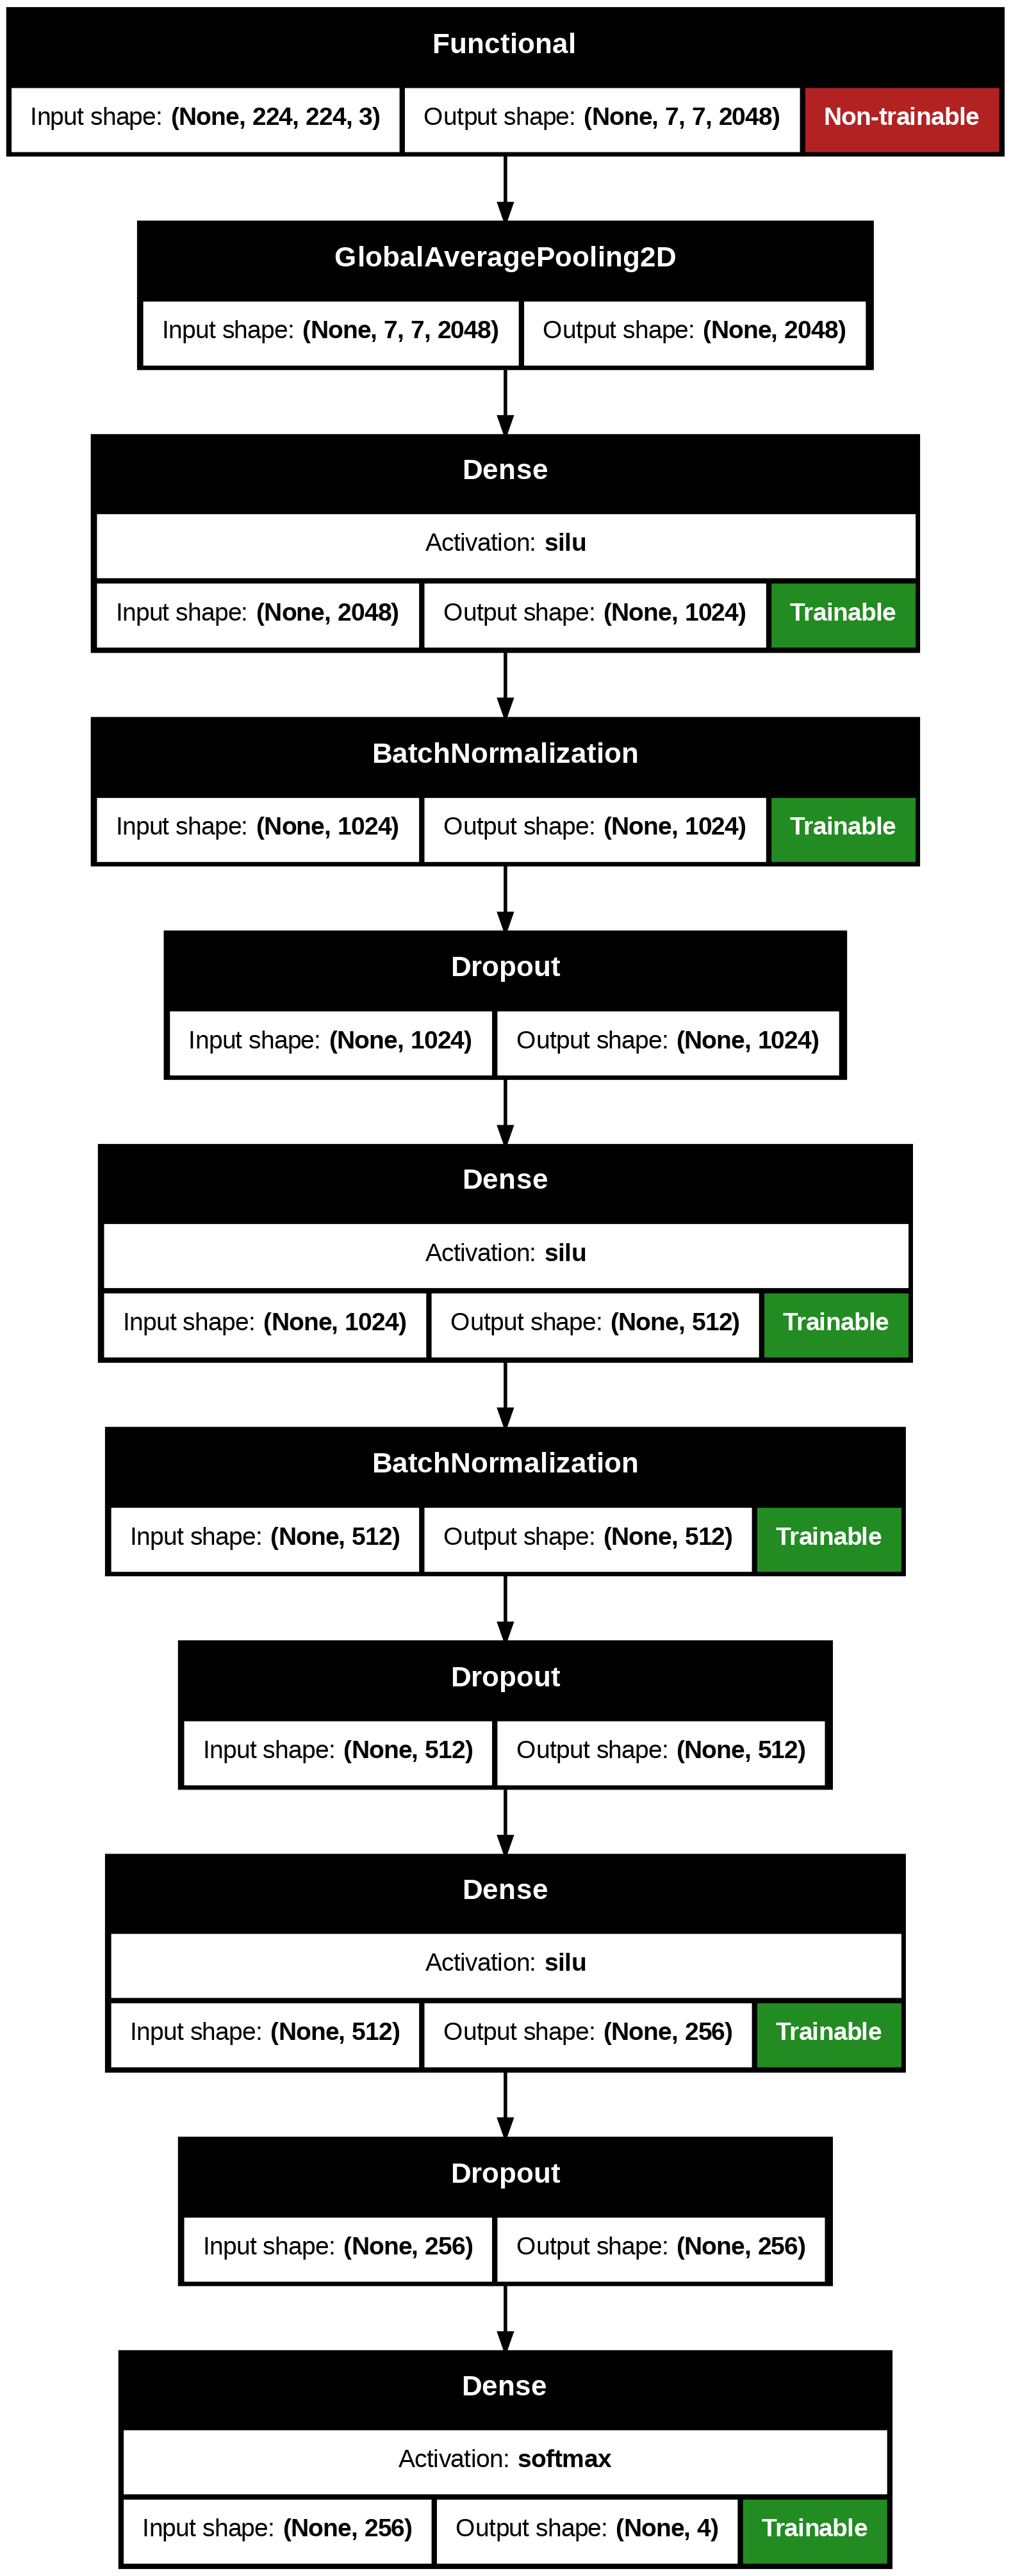

In [15]:
tf.keras.utils.plot_model(model,dpi=200,show_trainable=True,show_layer_activations=True,show_shapes=True)

In [16]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'],loss='categorical_crossentropy',jit_compile=True)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [18]:
history=model.fit(train_data,validation_data=val_data,batch_size=32,epochs=30,class_weight=class_weights_dict,callbacks=[early_stopper])

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745512674.257703     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/143 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.3125 - loss: 1.9717 

I0000 00:00:1745512681.236519     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 121s 695ms/step - accuracy: 0.5635 - loss: 1.1871 - val_accuracy: 0.6547 - val_loss: 0.9484
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 67s 443ms/step - accuracy: 0.7730 - loss: 0.6504 - val_accuracy: 0.7441 - val_loss: 0.6730
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 65s 436ms/step - accuracy: 0.8016 - loss: 0.5647 - val_accuracy: 0.7686 - val_loss: 0.6421
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 439ms/step - accuracy: 0.8222 - loss: 0.5057 - val_accuracy: 0.7783 - val_loss: 0.5857
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 427ms/step - accuracy: 0.8357 - loss: 0.4678 - val_accuracy: 0.7862 - val_loss: 0.5970
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 428ms/step - accuracy: 0.8221 - loss: 0.4861 - val_accuracy: 0.8046 - val_loss: 0.5630
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 64s 423ms/step - accuracy: 0.8542 - loss: 0.4227 - val_accuracy: 0.7905 - val_loss: 0.5949
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 67s 444ms/step - accuracy: 0.8579 - loss: 0.4033 - va

In [19]:
base_model.trainable=True

In [20]:
model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'],jit_compile=True)

In [21]:
history=model.fit(train_data,validation_data=val_data,verbose=1,callbacks=[early_stopper],class_weight=class_weights_dict,batch_size=32,epochs=15)

Epoch 1/15


E0000 00:00:1745514077.898318     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745514078.103301     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745514079.195752     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745514079.387611     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745514080.293435     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

  7/143 ━━━━━━━━━━━━━━━━━━━━ 56s 416ms/step - accuracy: 0.6282 - loss: 1.1813

E0000 00:00:1745514105.940349     128 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745514106.143110     128 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745514107.083491     128 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745514107.273323     128 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745514108.094405     128 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

143/143 ━━━━━━━━━━━━━━━━━━━━ 167s 666ms/step - accuracy: 0.7041 - loss: 0.8919 - val_accuracy: 0.7748 - val_loss: 0.7426
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 440ms/step - accuracy: 0.8432 - loss: 0.4555 - val_accuracy: 0.7528 - val_loss: 0.7100
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 67s 445ms/step - accuracy: 0.8716 - loss: 0.3729 - val_accuracy: 0.7949 - val_loss: 0.6063
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 456ms/step - accuracy: 0.8927 - loss: 0.3195 - val_accuracy: 0.8256 - val_loss: 0.4947
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 459ms/step - accuracy: 0.8967 - loss: 0.2879 - val_accuracy: 0.8440 - val_loss: 0.4299
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 459ms/step - accuracy: 0.9148 - loss: 0.2334 - val_accuracy: 0.8615 - val_loss: 0.3925
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 458ms/step - accuracy: 0.9139 - loss: 0.2497 - val_accuracy: 0.8782 - val_loss: 0.3548
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 453ms/step - accuracy: 0.9238 - loss: 0.2171 - va

In [22]:
test_loss,test_accuracy=model.evaluate(train_data,verbose=1)
print(f"\nTest Accuracy: {test_accuracy * 100:.4f}%")

143/143 ━━━━━━━━━━━━━━━━━━━━ 62s 430ms/step - accuracy: 0.9802 - loss: 0.0643

Test Accuracy: 98.0092%


In [23]:
val_loss,val_accuracy=model.evaluate(val_data,verbose=1)
print(f"Validation accuracy: {val_accuracy * 100:.4f}%")

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9297 - loss: 0.1973
Validation accuracy: 92.7257%


In [24]:
import numpy as np
y_pred=model.predict(test_data)
y_pred_class=np.argmax(y_pred,axis=1)
y_true=test_data.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step


In [25]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,classification_report,confusion_matrix


accuracy=accuracy_score(y_true,y_pred_class)
precision=precision_score(y_true,y_pred_class,average='weighted')
recall=recall_score(y_true,y_pred_class,average='weighted')
f1=f1_score(y_true,y_pred_class,average='weighted')


print("\nPerformance Metrics Breakdown:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Performance Metrics Breakdown:
Accuracy: 0.9451
Precision: 0.9455
Recall: 0.9451
F1-Score: 0.9448


In [26]:
class_labels=list(val_data.class_indices.keys())

In [27]:
print("Classification Report:")
print(classification_report(y_true,y_pred_class,target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.92      0.94       300
  meningioma       0.91      0.88      0.90       306
     notumor       0.99      0.98      0.98       405
   pituitary       0.92      0.99      0.95       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.94      1311



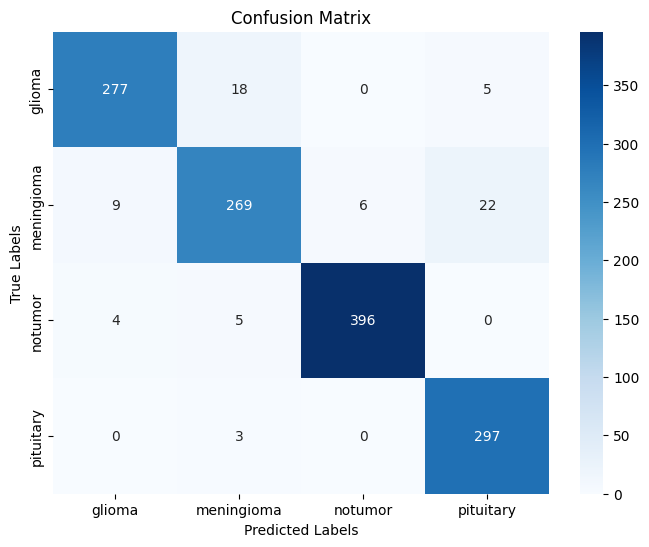

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
# Confusion Matrix
cm=confusion_matrix(y_true,y_pred_class)
# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=class_labels,yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

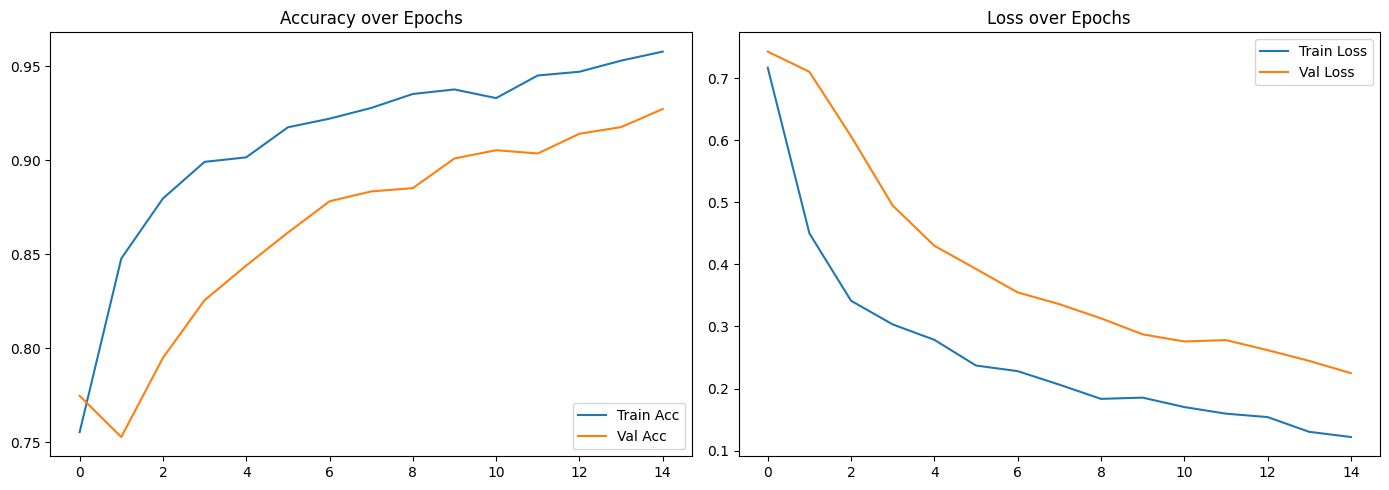

In [29]:
import matplotlib.pyplot as plt

# Retrieve metrics
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range=range(len(acc))

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Train Acc')
plt.plot(epochs_range,val_acc,label='Val Acc')
plt.legend(loc='lower right')
plt.title('Accuracy over Epochs')

# Loss
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Train Loss')
plt.plot(epochs_range,val_loss,label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss over Epochs')

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()

In [30]:
from tensorflow.keras.models import save_model
save_model(model,'brain_tumor_xception.h5')